<img src="yelp_logo.png" width="400">

# Analyzing Yelp Reviews

### Import libraries

In [117]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark
from pyspark import sql
import re
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from pyspark.sql.functions import udf
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml import Pipeline


ImportError: cannot import name 'RegressionEvaluatorv' from 'pyspark.ml.evaluation' (//anaconda3/lib/python3.7/site-packages/pyspark/ml/evaluation.py)

### Create Spark session

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Load Data

#### Dataset available at: https://www.kaggle.com/yelp-dataset/yelp-dataset

In [40]:
path_business = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_business.json'
#path_checkin = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_checkin.json'
path_review = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_review.json'
#path_tip = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_tip.json'
#path_user = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_user.json'
business_df = spark.read.json(path_business)
#checkin_df = spark.read.json(path_checkin)
review_df = spark.read.json(path_review)
#tip_df = spark.read.json(path_tip)
#user_df = spark.read.json(path_user)


In [4]:
#business_df.count()
#review_df.count()
#business_df.toPandas().head(5)
#user_df.count()
business_df.toPandas().head(5)



,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,"(None, None, None, None, None, None, None, Non...",1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"(None, None, u'full_bar', {'romantic': False, ...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"(9:0-1:0, 9:0-0:0, 9:0-1:0, 9:0-0:0, 9:0-0:0, ...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","(None, None, u'beer_and_wine', {'romantic': Fa...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"(17:30-22:0, 17:30-21:30, 17:30-22:0, 17:30-21...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"(8:0-17:0, 8:0-17:0, None, None, 8:0-17:0, 8:0...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","(None, None, None, None, None, None, None, Non...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"(7:0-23:0, 7:0-23:0, 7:0-23:0, 7:0-23:0, 7:0-2...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [42]:
# calculate the opening hour of each observation
# split the hour column 

#business_df.select(fn.col('hours')[0].alias('Fri')).head(5)
business_df = business_df.withColumn("Fri", business_df['hours.Friday']).withColumn("Mon", business_df['hours.Monday']).withColumn("Sat", business_df['hours.Saturday']).withColumn("Sun", business_df['hours.Sunday']).withColumn("Thu", business_df['hours.Thursday']).withColumn("Tue", business_df['hours.Tuesday']).withColumn("Wed", business_df['hours.Wednesday'])
business_df.printSchema()

#calculate duration by subtracting


root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [74]:
#select a new dataframe to calculate the openning time 
business_date = business_df.select('business_id', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun')
business_date.toPandas().head(5)

# user difine funtion, caculate how many hour is opening every day
@udf
def diff_time(time):
    if time is None:
        return 0
    else:
        times = time.split('-')
        time1 = list(map(lambda x : int(x), times[0].split(':')))
        time2 = list(map(lambda x : int(x), times[1].split(':')))
        if time2[0] < time1[0]:
            diff = (24+time2[0]-time1[0])+((time2[1]/60)-(time1[1]/60))
            return diff
        else:
            diff = (time2[0]-time1[0])+((time2[1]/60)-(time1[1]/60))
            return diff
business_date = business_date.withColumn('Mon', diff_time('Mon'))
business_date = business_date.withColumn('Tue', diff_time('Tue'))
business_date = business_date.withColumn('Wed', diff_time('Wed'))
business_date = business_date.withColumn('Thu', diff_time('Thu'))
business_date = business_date.withColumn('Fri', diff_time('Fri'))
business_date = business_date.withColumn('Sat', diff_time('Sat'))
business_date = business_date.withColumn('Sun', diff_time('Sun'))

business_date.show(5)
        
         

+--------------------+----+----+----+----+----+----+----+
|         business_id| Mon| Tue| Wed| Thu| Fri| Sat| Sun|
+--------------------+----+----+----+----+----+----+----+
|1SWheh84yJXfytovI...|   0|   0|   0|   0|   0|   0|   0|
|QXAEGFB4oINsVuTFx...|15.0|15.0|15.0|15.0|16.0|16.0|15.0|
|gnKjwL_1w79qoiV3I...| 4.0|   0| 4.0| 4.0| 4.5| 4.5| 3.5|
|xvX2CttrVhyG2z1dF...| 9.0| 9.0| 9.0| 9.0| 9.0|   0|   0|
|HhyxOkGAM07SRYtlQ...|16.0|16.0|16.0|16.0|16.0|16.0|16.0|
+--------------------+----+----+----+----+----+----+----+
only showing top 5 rows



In [75]:
#select helpful columns which could help predict star 
business_df.toPandas().head(5)
#business_df.printSchema()
new_business = business_df.select('business_id', 'is_open', 'review_count','city')
new_business.show(5)


+--------------------+-------+------------+-----------+
|         business_id|is_open|review_count|       city|
+--------------------+-------+------------+-----------+
|1SWheh84yJXfytovI...|      0|           5|    Phoenix|
|QXAEGFB4oINsVuTFx...|      1|         128|Mississauga|
|gnKjwL_1w79qoiV3I...|      1|         170|  Charlotte|
|xvX2CttrVhyG2z1dF...|      1|           3|   Goodyear|
|HhyxOkGAM07SRYtlQ...|      1|           4|  Charlotte|
+--------------------+-------+------------+-----------+
only showing top 5 rows



# REMEMBER TO REMOVE THIS, THIS SAMPLES ONLY 1/1000 OF THE DATA!


In [76]:

#business_df = business_df.sample(False, 0.001, seed = 123)
#checkin_df = checkin_df.sample(False, 0.001, seed = 123)
review_df = review_df.sample(False, 0.005, seed = 123)
#tip_df = tip_df.sample(False, 0.001, seed = 123)
#user_df = user_df.sample(False, 0.001, seed = 123)



### Check schema

In [33]:
# Check schema
#business_df.printSchema()
#business_df.toPandas().head(5)
#checkin_df.printSchema()
#checkin_df.toPandas()
review_df.printSchema()
#review_df.toPandas().head(5)


#tip_df.printSchema()
#tip_df.toPandas().head(5)
#user_df.printSchema()
#user_df.toPandas().head(5)

#show the first row of df



root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,YSUcHqlKMPHHJ_cTrqtNrA,0,2017-12-29 13:55:19,0,E6B-2U2sGG3xgmnNWZAEew,1.0,Came here on a Thursday night at 6:30 p.m. My ...,0,DbccYu3OppWKl21OanZnTg
1,faPVqws-x-5k2CQKDNtHxw,0,2018-08-04 20:22:15,0,w1I8U4cJ4QGaXA98ImNrbA,5.0,"Service was amazing, Christina was extremely t...",0,rJNdeta-dYO2YcJ3u5JxnA
2,Wxxvi3LZbHNIDwJ-ZimtnA,2,2011-07-28 09:06:59,4,Sft1a3j3Hst44CG9gbww0Q,1.0,I am so blown away by this sophisticated & bea...,8,FBxhaS2bPmxwT3I8r3CmkQ
3,XqJG7Ux_mMfMJnyG2Q4m2Q,0,2018-08-04 20:49:20,0,sMh-VUwO64K-VvKEOtrZiw,5.0,What an incredible experience this was. There ...,0,zsGH_1XyUxuP5O34WL6eLg
4,pJQSdbrtQQVstMUUIICSsA,0,2011-01-09 02:59:52,0,1ue9DOGcYUPXU-NlJLLW7w,3.0,Reclining chairs with arm rests that rise are ...,0,lZmfLRHJTCxxkq8wlKONlA


In [80]:
#add some features to the review dataset
join_table = review_df.join(new_business, ['business_id'])
join_table = join_table.join(business_date, ['business_id'])
#join_table.toPandas().head(5)




### Check number of NULL values per column

In [81]:
#for col in join_table.columns:
#    print(col, ':', join_table.filter(join_table[col].isNull()).count())
print(1,":", join_table.filter(join_table['is_open']==1).count())

1 : 28922


### View data

In [82]:
join_table.toPandas().head(5)
#join_table.count()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_open,review_count,city,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,--9e1ONYQuAa-CB_Rrw7Tw,0,2009-03-22 01:49:45,0,qx3Ba91UzIasxowH0f2x5Q,4.0,Besides having to finance your meal with a 20%...,0,be4K9MZmJTN6TSbpP1O3tw,1,1613,Las Vegas,5.0,5.0,5.0,5.0,5.5,5.5,5.0
1,--9e1ONYQuAa-CB_Rrw7Tw,2,2011-10-01 15:04:51,1,CSedaZsqWDBG8_tJ0NgTVw,5.0,The only thing that would make dining at Delmo...,2,kS1-hIOkQlUvfmPL2WyvTA,1,1613,Las Vegas,5.0,5.0,5.0,5.0,5.5,5.5,5.0
2,--9e1ONYQuAa-CB_Rrw7Tw,1,2009-03-31 14:43:27,1,Xx6obtR7ddCmsPMksKV0FA,5.0,I'd say it's probably the best steakhouse i ev...,1,Goeb2D2E99xss3tMrX--FQ,1,1613,Las Vegas,5.0,5.0,5.0,5.0,5.5,5.5,5.0
3,--9e1ONYQuAa-CB_Rrw7Tw,0,2011-12-10 13:53:28,0,sj_9jrJYdCHEDPKwCFVn9Q,5.0,One of the best meals. The steaks are aged an...,0,Y7ozCwtq7sr16-DJw_ndDw,1,1613,Las Vegas,5.0,5.0,5.0,5.0,5.5,5.5,5.0
4,--9e1ONYQuAa-CB_Rrw7Tw,1,2012-07-05 03:49:38,0,kMffQjcePIsLul3y1dmf_w,5.0,I have been coming to this place for the last ...,2,m2n2KDQIyqPzn9wU5GjALA,1,1613,Las Vegas,5.0,5.0,5.0,5.0,5.5,5.5,5.0


## First, Try to predict whether the merchant is open

### Don't use text column for the first time

### Buile a logistic regression model

In [93]:

X = join_table.select('cool', 'funny', 'stars','useful','review_count','Mon','Tue','Wed','Thu','Fri','Sat','Sun').toPandas()
y = join_table.select('is_open').toPandas()


In [96]:
#use smote to oversample the minority group
os = SMOTE(random_state =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns )


In [97]:
#name is_opan as 'y'
os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
X=os_data_X
y=os_data_y['y']



In [98]:
#implement the model
logit_model=sm.Logit(y,X)
result=logit_model.fit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



Optimization terminated successfully.
         Current function value: 0.692231
         Iterations 4
Accuracy of logistic regression classifier on test set: 0.50


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)





[[2240 2065]
 [2166 2063]]


### Build logistic regression model for later predictions

In [83]:
# confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.58      0.58      6116
           1       0.58      0.59      0.59      6046

    accuracy                           0.59     12162
   macro avg       0.59      0.59      0.59     12162
weighted avg       0.59      0.59      0.59     12162



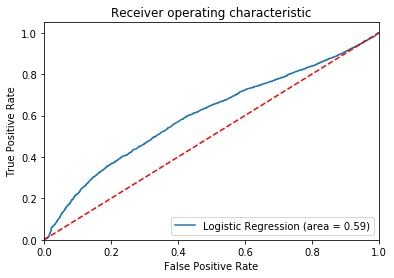

In [84]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Second, run another logistic regression model to predict stars level

In [141]:
yelp_df = join_table.select('cool', 'funny', 'is_open','useful','review_count','Mon','Tue','Wed','Thu','Fri','Sat','Sun','stars')
#yelp_df.show(5)
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
yelp_df = yelp_df.withColumn("Mon", col("Mon").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Tue", col("Tue").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Wed", col("Wed").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Thu", col("Thu").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Fri", col("Fri").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Sat", col("Sat").cast(DoubleType()))
yelp_df = yelp_df.withColumn("Sun", col("Sun").cast(DoubleType()))
yelp_df.printSchema()

root
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- is_open: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- review_count: long (nullable = true)
 |-- Mon: double (nullable = true)
 |-- Tue: double (nullable = true)
 |-- Wed: double (nullable = true)
 |-- Thu: double (nullable = true)
 |-- Fri: double (nullable = true)
 |-- Sat: double (nullable = true)
 |-- Sun: double (nullable = true)
 |-- stars: double (nullable = true)



In [142]:
from pyspark.sql import functions as fn
from pyspark.sql.types import DecimalType
yelp_df = yelp_df.withColumn("stars", fn.when(fn.col('stars')>3,1).otherwise(0))




In [125]:
log_model = Pipeline(stages=[feature.VectorAssembler(inputCols = ['cool', 'funny', 'is_open','useful','review_count','Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                                                    outputCol='features'),
                            classification.LogisticRegression(labelCol = 'stars', featuresCol = 'features')])

In [ ]:
#split df into training and test dataframe

In [127]:
training,test = yelp_df.randomSplit([0.8,0.2],0)

In [128]:
log_model_fit = log_model.fit(training)

In [129]:
log_model_fit.transform(test).toPandas().head()

,cool,funny,is_open,useful,review_count,Mon,Tue,Wed,Thu,Fri,Sat,Sun,stars,features,rawPrediction,probability,prediction
0,0,0,0,0,17,9.0,9.0,9.0,9.0,9.0,9.0,0.0,0,"[0.0, 0.0, 0.0, 0.0, 17.0, 9.0, 9.0, 9.0, 9.0,...","[0.06959327020875195, -0.06959327020875195]","[0.5173912989567454, 0.4826087010432546]",0.0
1,0,0,0,0,64,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0,"[0.0, 0.0, 0.0, 0.0, 64.0, 12.0, 12.0, 12.0, 1...","[0.6761002116389888, -0.6761002116389888]","[0.66286775001159, 0.33713224998841]",0.0
2,0,0,0,0,173,0.0,5.5,5.5,5.5,5.5,10.0,9.5,1,"[0.0, 0.0, 0.0, 0.0, 173.0, 0.0, 5.5, 5.5, 5.5...","[0.74180366594396, -0.74180366594396]","[0.6773901423405683, 0.32260985765943173]",0.0
3,0,0,1,0,41,0.0,10.0,10.0,10.0,8.0,8.0,0.0,1,"[0.0, 0.0, 1.0, 0.0, 41.0, 0.0, 10.0, 10.0, 10...","[-0.8123861871097461, 0.8123861871097461]","[0.3073822469164279, 0.6926177530835722]",1.0
4,0,0,1,0,44,8.0,8.0,8.0,8.0,9.0,9.0,8.0,1,"[0.0, 0.0, 1.0, 0.0, 44.0, 8.0, 8.0, 8.0, 8.0,...","[0.28814922584448244, -0.28814922584448244]","[0.5715429725216422, 0.42845702747835784]",0.0


In [130]:
#calculate the predicted percert 1
log_model_fit.transform(test).select(fn.avg(fn.expr('prediction = 1.0').cast('float'))).show()

+--------------------------------------+
|avg(CAST((prediction = 1.0) AS FLOAT))|
+--------------------------------------+
|                    0.2599700149925038|
+--------------------------------------+



In [131]:
#calculates the percent 1 in the orginal dataframe
yelp_df.select(fn.avg(fn.expr('stars = 1.0').cast('float'))).show()

+---------------------------------+
|avg(CAST((stars = 1.0) AS FLOAT))|
+---------------------------------+
|                0.438707929435848|
+---------------------------------+



In [139]:
log_model_fit.stages[-1].coefficients

DenseVector([0.3468, -0.2582, 0.3609, -0.1695, 0.0, -0.0422, 0.018, 0.0239, 0.0748, 0.0044, -0.0288, -0.0631])

this is the same logistic regression model without using pyspark

In [143]:
#os = SMOTE(random_state =0)
#X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=0)
#columns = X_train.columns
#os_data_X, os_data_y=os.fit_sample(X_train, y_train)
#os_data_X = pd.DataFrame(data=os_data_X, columns=columns )
X_2 = yelp_df.select('cool', 'funny','is_open', 'useful','review_count','Mon','Tue','Wed','Thu','Fri','Sat','Sun').toPandas()
y_2 = yelp_df.select('stars').toPandas()



In [135]:
#name stars as 'y'
#os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
#X=os_data_X
#y=os_data_y['y']
#data_y= pd.DataFrame(data=y_train, columns=['y'])
#data_X = pd.DataFrame(data=X_train, columns=columns )
#X=data_X
#y=data_y['y']





In [144]:
#implement the model
logit_model=sm.Logit(y_2,X_2)
result=logit_model.fit()

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Optimization terminated successfully.
         Current function value: 0.647541
         Iterations 5
Accuracy of logistic regression classifier on test set: 0.65


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


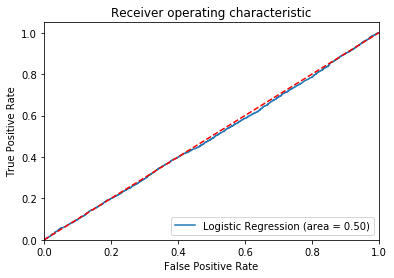

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# Using text columns